In [1]:
from wingflattenfuncs import P2, P3
from wingflattenfuncs import WingShape
from wingflattenfuncs import loadwingtrimlines, trimlinestopolygons, exportpolygonsobj

import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
print("Parametrization in uv: ", wingshape.urange, wingshape.vrange)

trimfile = "segmentedwing.txt"
snodes, paths = loadwingtrimlines(trimfile)
nodes = dict((n, wingshape.sevalconvO(p))  for n, p in snodes.items())  

# approximately flat and in metres (based around section 7) without the compression at the leading edge

No pygmsh here
Parametrization in uv:  (0, 6.11206792886613) (-1.377293405726668, 1.377293405726668)


<IPython.core.display.Javascript object>


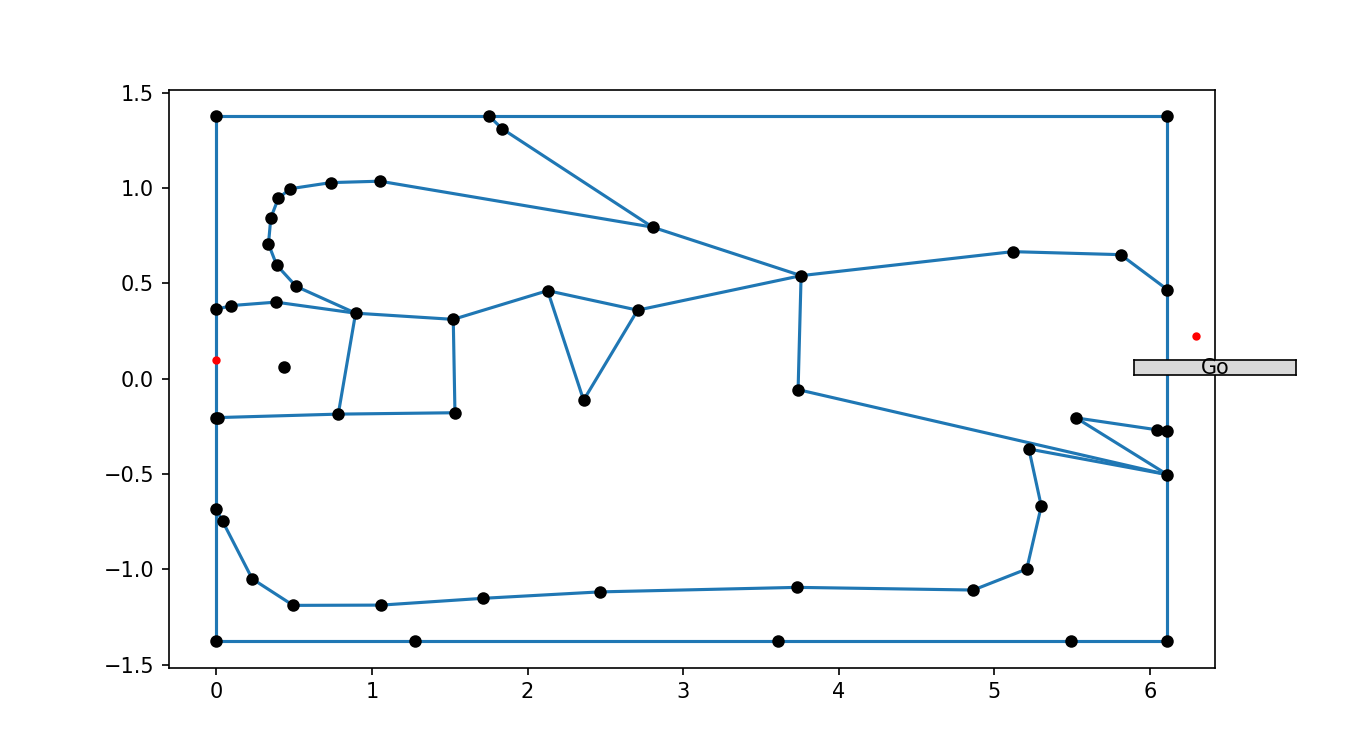

In [69]:
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib import collections  as mc
from matplotlib.widgets import Button

rnodes = nodes

cursor1 = None
cursor2 = None
def pointsdata():
    return zip(*rnodes.values())
def cursordata():
    return zip(*[cursor1 or P2(0,0), cursor2 or P2(0,0.1)])
def legsdata():
    return [[rnodes[paths[i]], rnodes[paths[i+1]]]  for i in range(0, len(paths), 2)]
def commitlineedit(paths, n1, n2):
    for i in range(0, len(paths), 2):
        if (n1 == paths[i] and n2 == paths[i+1]) or (n1 == paths[i+1] and n2 == paths[i]):
            del paths[i:i+2]
            return
    paths.extend([n1, n2])


fig = plt.figure(figsize=(9,5))
axpara = fig.add_subplot(1,1,1)
lc = mc.LineCollection(legsdata())
lupdater = axpara.add_collection(lc)
mupdater, = axpara.plot(*pointsdata(), color='black', linestyle='none', marker='o', markersize=5)
cursorupdater, = axpara.plot(*cursordata(), color='red', linestyle='none', marker='o', markersize=3)

axpara.autoscale()

events = [ ]
nodenamedown = None
nodeclickdistance = 0.04
Dlineedits = [ ]

def button_press_callback(event):
    global nodenamedown, cursor1, cursor2
    if event.inaxes == axpara:
        mp = P2(event.xdata, event.ydata)
        l, nn = min(((mp - p).Len(), nn)  for nn, p in rnodes.items())
        if l < nodeclickdistance:
            if event.button == 1:
                nodenamedown = nn
                cursor1 = None
                cursorupdater.set_data(cursordata())
            elif event.button == 3:
                nodenamedown = nn
                cursor2 = rnodes[nodenamedown]
                cursorupdater.set_data(cursordata())
            fig.canvas.draw_idle()

def button_release_callback(event):
    global nodenamedown, cursor2
    events.append(event)
    if nodenamedown is not None:
        if cursor2 is not None:
            l, nn = min(((cursor1 - p).Len(), nn)  for nn, p in rnodes.items())
            Dlineedits.append((l, nodenamedown, nn))
            if l < nodeclickdistance and nodenamedown != nn:
                commitlineedit(paths, nodenamedown, nn)
                lupdater.set_segments(legsdata())
            nodenamedown = None
            cursor2 = None
        nodenamedown = None
        fig.canvas.draw_idle()

        
def motion_notify_callback(event):
    global cursor1
    if event.inaxes == axpara:
        mp = P2(event.xdata, event.ydata)
        if nodenamedown is not None and cursor2 is None:
            rnodes[nodenamedown] = wingshape.clampuv(mp)
            mupdater.set_data(pointsdata())
            lupdater.set_segments(legsdata())
            fig.canvas.draw_idle()
        else:
            cursor1 = mp
            cursorupdater.set_data(cursordata())
            fig.canvas.draw_idle()

        
def buttongo(event):
    pass

def key_press_callback(event):
    events.append(event)
    
axres = plt.axes([0.84, 0.5, 0.12, 0.02])
bres = Button(axres, 'Go')
bres.on_clicked(buttongo)
fig.canvas.mpl_connect('button_press_event', button_press_callback)
fig.canvas.mpl_connect('button_release_event', button_release_callback)
fig.canvas.mpl_connect('motion_notify_event', motion_notify_callback)
fig.canvas.mpl_connect('key_press_event', key_press_callback)

plt.show()

In [61]:
n1, n2 = lineedits[0][0], lineedits[0][1]
commitlineedit(paths, n1, n2)
len(paths)


116


116

In [67]:

Dlineedits


[(0.0, 'a108', 'a108')]

In [26]:
events[-1].button == 3

True

In [ ]:
def exchyz(p):
    return (p[0], p[2], p[1])
def points3ddata():
    res = [ ]
    for p in rnodes.values():
        res.append(exchyz(wingshape.seval((-p[1], p[0]))))
    return zip(*res)
def legs3ddata(step=0.25):
    res = [ ]
    for i in range(0, len(paths), 2):
        p0, p1 = rnodes[paths[i]], rnodes[paths[i+1]]
        n = max(1, int(math.ceil((p0 - p1).Len()/step)))
        p = wingshape.seval((-p0[1], p0[0]))
        for i in range(n):
            l = (i+1.0)/n
            pn = p0*(1-l) + p1*l
            pd = wingshape.seval((-pn[1], pn[0]))
            res.append([exchyz(p), exchyz(pd)])
            p = pd
    return res


In [4]:
events